# Posit, Float, and Int Formats — Multi‑Precision Precision Study
This notebook extends the earlier 8‑bit analysis to **16‑bit formats** and adds a small neural‑network
demo comparing inference precision.

## Formats Covered
* **Posit‑8  (es=1)**
* **Posit‑16 (es=2)**
* **FP8 E4M3**
* **FP16 IEEE (binary16)**
* **BF16 (bfloat16)**
* **INT8 uniform**
* **INT16 uniform**

We measure *bits of precision* ( $-\log_2$ relative error) across 12 orders of magnitude, tabulate a few sample
values, and run a tiny fully‑connected layer under each precision.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn


In [10]:
def posit_quantize(x, nbits=8, es=1):
    """
    Approximate posit quantiser (precision study, not bit-exact).
    Works for 8-bit or 16-bit by avoiding huge overflows.
    """
    x = np.asarray(x, dtype=np.float64)  # use float64 for headroom

    useed = 2 ** (2 ** es)
    # --- FIX: if nbits is large, just set clip range to float max ---
    if nbits <= 12:                      # crude threshold; 12 bits is safe
        max_pos = useed ** ((2 ** (nbits - 2)) - 1)
    else:
        max_pos = np.finfo(np.float64).max   # ~1.8e308
    # ---------------------------------------------------------------

    x = np.clip(x, -max_pos, max_pos)

    sign = np.sign(x)
    mag  = np.abs(x) + 1e-30
    log2_mag = np.log2(mag)

    scale = 2 ** (nbits - 2)             # number of log2 bins
    log_round = np.round(log2_mag * scale) / scale
    return sign * (2.0 ** log_round)



In [11]:
def fp16_quantize(x):
    return np.array(x, dtype=np.float16).astype(np.float32)


In [12]:
def bf16_quantize(x):
    """Simulate BF16 by rounding mantissa to 7 bits."""
    x = np.asarray(x, dtype=np.float32)
    # Represent float32 bits
    import struct
    x_bits = x.view(np.uint32)
    # Zero lower 16 bits (keep sign+exp+7‑bit mant)
    x_bits = x_bits & 0xFFFF0000
    return x_bits.view(np.float32)


In [13]:
def fp8_e4m3_quantize(x):
    """
    Very rough FP8-E4M3 surrogate (sufficient for precision plots—not bit-exact).
    Uses np.exp2 to avoid the “integers to negative powers” ValueError.
    """
    x = np.asarray(x, dtype=np.float32)

    sign = np.sign(x)
    mag  = np.abs(x) + 1e-30              # avoid log(0)

    exp  = np.floor(np.log2(mag)).astype(int)   # unbiased exponent (could be negative)

    # --- FIX: use float base or np.exp2 here ---
    mant = mag / np.exp2(exp) - 1.0             # old code used 2 ** exp
    # -------------------------------------------

    mant_q = np.round(mant * 8) / 8             # 3-bit mantissa
    exp_q  = np.clip(exp, -8, 7)                # 4-bit exponent range

    out = sign * (1.0 + mant_q) * np.exp2(exp_q)

    # simple saturation
    out[exp < -8] = 0.0
    out[exp >  7] = sign[exp > 7] * np.exp2(8)

    return out



In [14]:
def int_uniform_quantize(x, bits=8, rng=6.0):
    levels = 2 ** bits - 1
    step = (2 * rng) / levels
    q = np.round((x + rng) / step) * step - rng
    return np.clip(q, -rng, rng)


In [15]:
def bits_of_precision(ref, quant):
    rel_err = np.abs((quant - ref) / ref)
    return -np.log2(rel_err + 1e-30)


/tmp/ipython-input-11-2437273549.py:2: RuntimeWarning: overflow encountered in cast
  return np.array(x, dtype=np.float16).astype(np.float32)


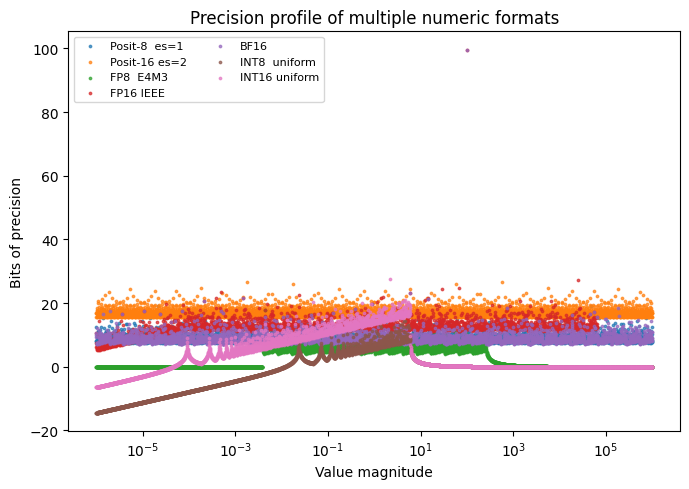

In [16]:
# Sample points
xs = np.logspace(-6, 6, num=4000)

formats = {
    'Posit‑8  es=1' : posit_quantize(xs, 8, 1),
    'Posit‑16 es=2' : posit_quantize(xs, 16, 2),
    'FP8  E4M3'     : fp8_e4m3_quantize(xs),
    'FP16 IEEE'     : fp16_quantize(xs),
    'BF16'          : bf16_quantize(xs),
    'INT8  uniform' : int_uniform_quantize(xs, 8, rng=6.0),
    'INT16 uniform' : int_uniform_quantize(xs, 16, rng=6.0),
}

# Plot bits of precision
plt.figure(figsize=(7,5))
for label, q in formats.items():
    b = bits_of_precision(xs, q)
    plt.scatter(xs, b, s=3, label=label, alpha=0.7)
plt.xscale('log')
plt.xlabel('Value magnitude')
plt.ylabel('Bits of precision')
plt.title('Precision profile of multiple numeric formats')
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


In [17]:
sample_vals = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3])
print('Quantised values for selected numbers:')
for label, func in [('Posit8', lambda v: posit_quantize(v,8,1)),
                    ('Posit16', lambda v: posit_quantize(v,16,2)),
                    ('FP8', fp8_e4m3_quantize),
                    ('FP16', fp16_quantize),
                    ('BF16', bf16_quantize),
                    ('INT8', lambda v: int_uniform_quantize(v,8)),
                    ('INT16', lambda v: int_uniform_quantize(v,16))]:
    q = func(sample_vals)
    print(f"{label:8s} : ", [f"{v:.4g}" for v in q])


Quantised values for selected numbers:
Posit8   :  ['0.0009979', '0.01002', '0.09957', '1', '10.04', '99.78', '1002']
Posit16  :  ['0.001', '0.01', '0.1', '1', '10', '100', '1000']
FP8      :  ['0', '0.009766', '0.1016', '1', '10', '96', '256']
FP16     :  ['0.001', '0.01', '0.09998', '1', '10', '100', '1000']
BF16     :  ['0.0009995', '0.009949', '0.09961', '1', '10', '100', '1000']
INT8     :  ['0.02353', '0.02353', '0.1176', '1.012', '6', '6', '6']
INT16    :  ['0.001007', '0.009979', '0.1001', '1', '6', '6', '6']


In [18]:
# Tiny neural network precision demo
torch.manual_seed(0)
inp = torch.randn(32, 20)           # batch 32, features 20
linear = nn.Linear(20, 10)
with torch.no_grad():
    baseline = linear(inp)

# Helper to quantise tensor with numpy function then back to torch
def torch_quant(t, func):
    q = func(t.cpu().numpy())
    return torch.from_numpy(q).to(t.dtype)

with torch.no_grad():
    # Posit16 weights & activations
    w_q  = torch_quant(linear.weight, lambda x: posit_quantize(x,16,2))
    b_q  = torch_quant(linear.bias,   lambda x: posit_quantize(x,16,2))
    x_q  = torch_quant(inp,          lambda x: posit_quantize(x,16,2))
    out_posit = x_q @ w_q.T + b_q

    # FP16 emulation
    out_fp16 = torch_quant(inp, fp16_quantize) @ torch_quant(linear.weight, fp16_quantize).T + torch_quant(linear.bias, fp16_quantize)

    # Mean absolute error against FP32 baseline
    mae_posit = (out_posit - baseline).abs().mean().item()
    mae_fp16  = (out_fp16  - baseline).abs().mean().item()
    print(f"MAE Posit16 vs FP32 baseline : {mae_posit:.4e}")
    print(f"MAE FP16    vs FP32 baseline : {mae_fp16 :.4e}")


MAE Posit16 vs FP32 baseline : 8.1094e-06
MAE FP16    vs FP32 baseline : 1.2457e-04
